In [1]:
import torch 
import random
from random import randint
from torch.nn import functional as F

__all__ = ['distribution_matching']

def compute_metric(selected, features):
    target_dist = features.sum(0).type(torch.float32)
    target_dist = target_dist / target_dist.sum() #normalize

    selected_dist = features[selected,:].sum(0).type(torch.float32)
    selected_dist = selected_dist/ selected_dist.sum() #normalize

    number = F.mse_loss( selected_dist, target_dist)
    return number

def distribution_matching(features, K_return=50, iterations= 1000, early_stopping = 0.00001):
    """ returns k indexe from globale_indices such that the returned indexed match the total feature distribution the best

    Parameters
    ----------
    features : torch.tensor NRxC
    K_return : int, optional
            number of returned indices, by default 50
    """
    indices = torch.arange( 0, features.shape[0] )
    start_indices = torch.randperm( indices.shape[0] )[:K_return]
    selected = torch.zeros( (indices.shape[0]), dtype=torch.bool)
    for i in range(start_indices.shape[0]):
        selected[start_indices[i]] = True
        
    
    old_metric = compute_metric( selected, features)
    for i in range(iterations):
        if old_metric < early_stopping:
            break
        
        current_selection = torch.where(selected)[0]
        candidate = current_selection[randint(0,K_return-1)]

        # get a new candidate sample
        while True:
            sample = randint(0,selected.shape[0]-1)
            if sample not in current_selection:
                break

        selected[ candidate ] = False
        selected[ sample ] = True
        new_metric = compute_metric( selected, features)

        if new_metric < old_metric:
            # keep candidate change
            old_metric = new_metric
        else:
            if random.random() < 0.05:
                old_metric = new_metric
            else:
                selected[ candidate ] = True
                selected[ sample ] = False
        
    return selected, old_metric



tensor(50) tensor(8.9843e-06) Total time 0.010588884353637695


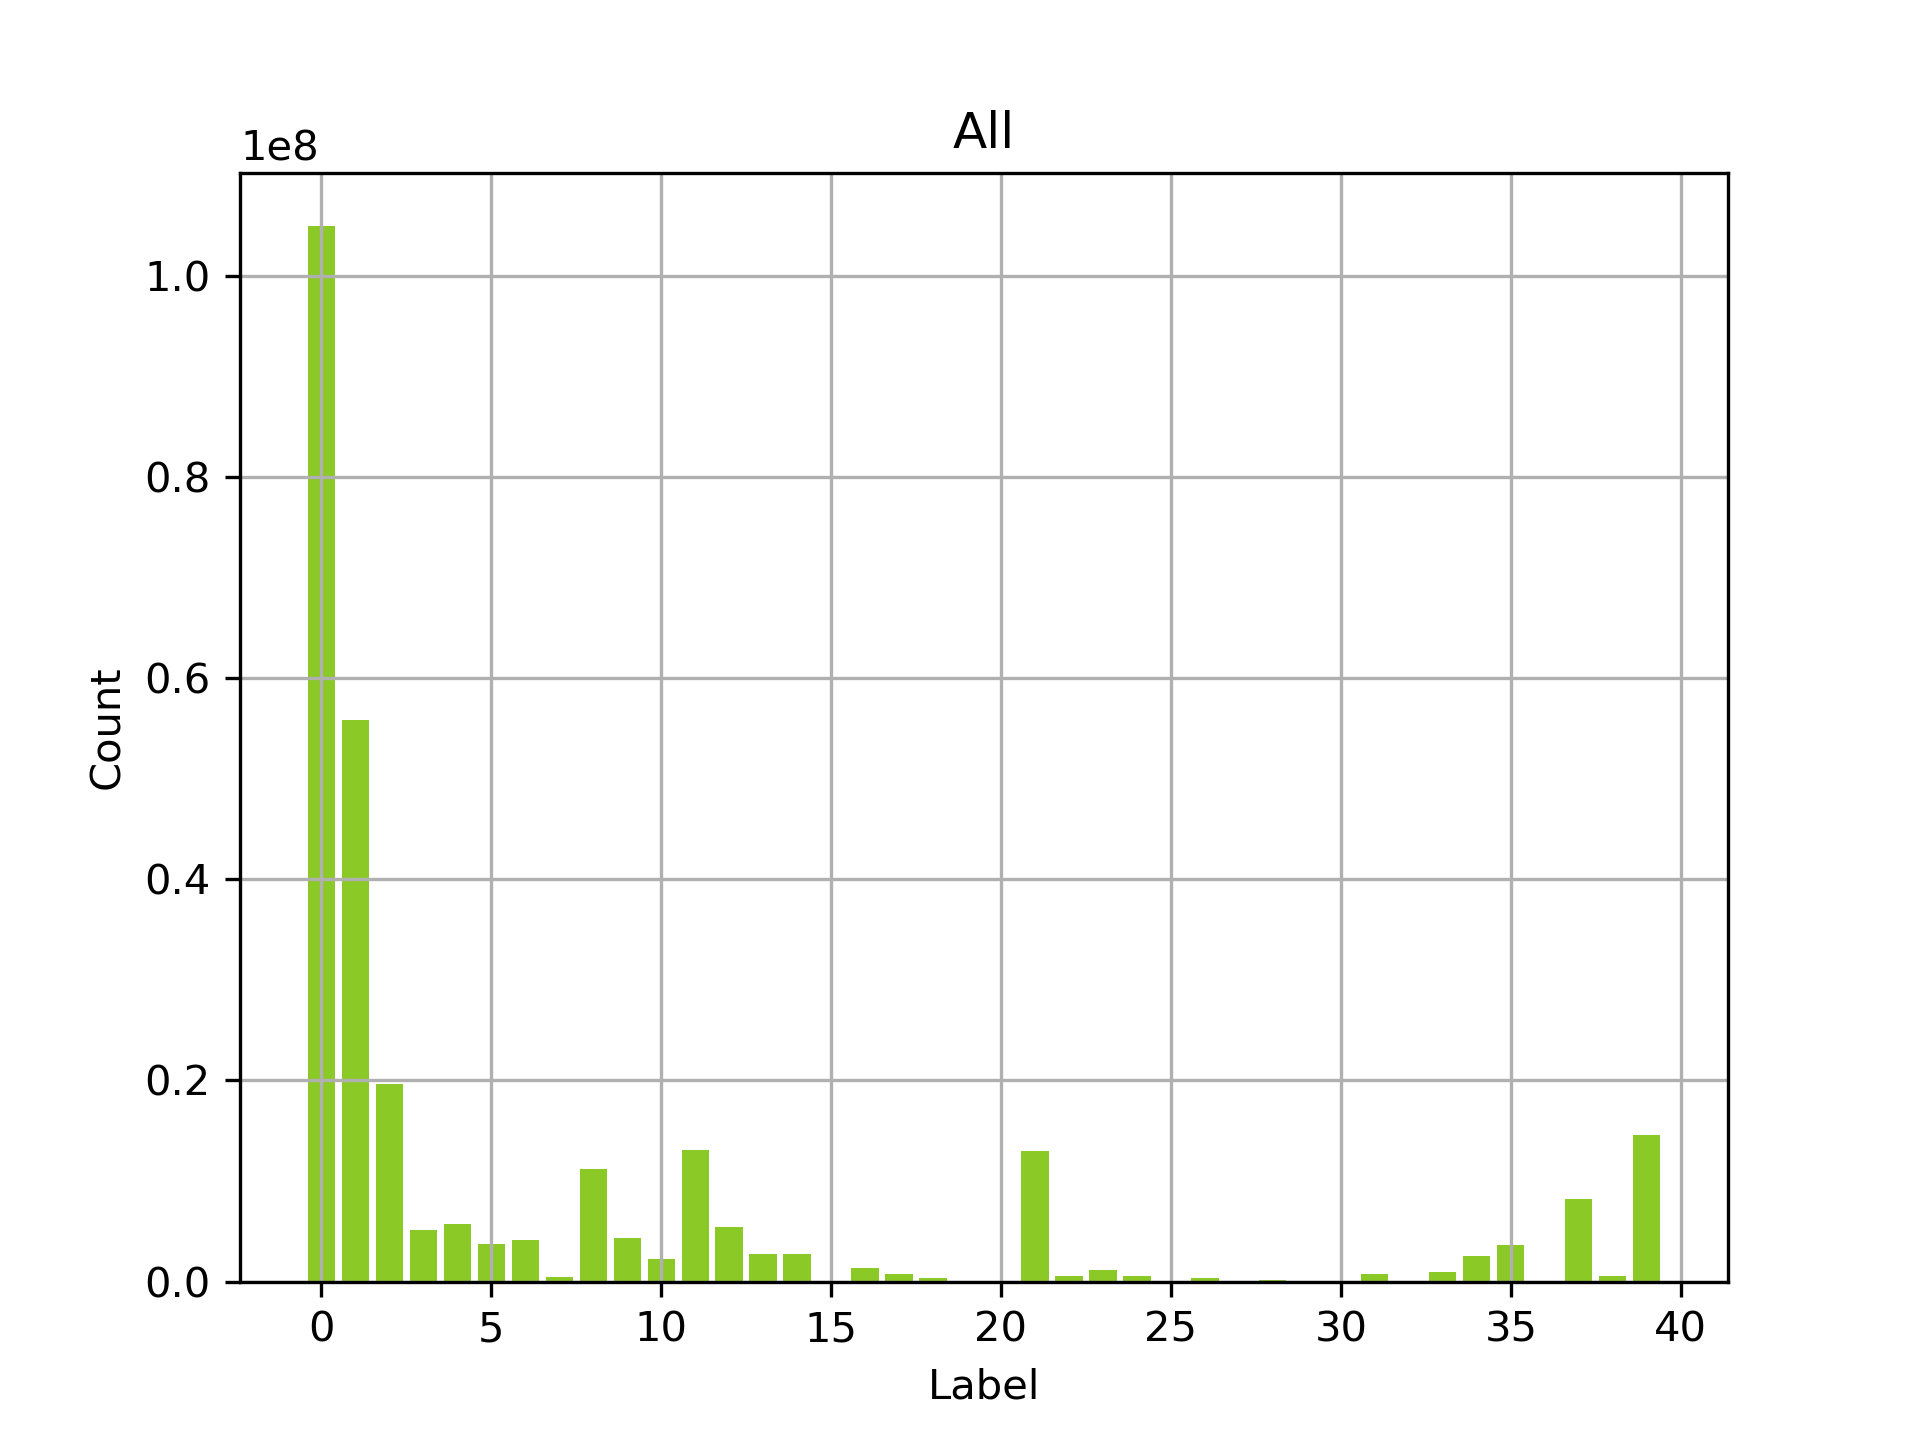

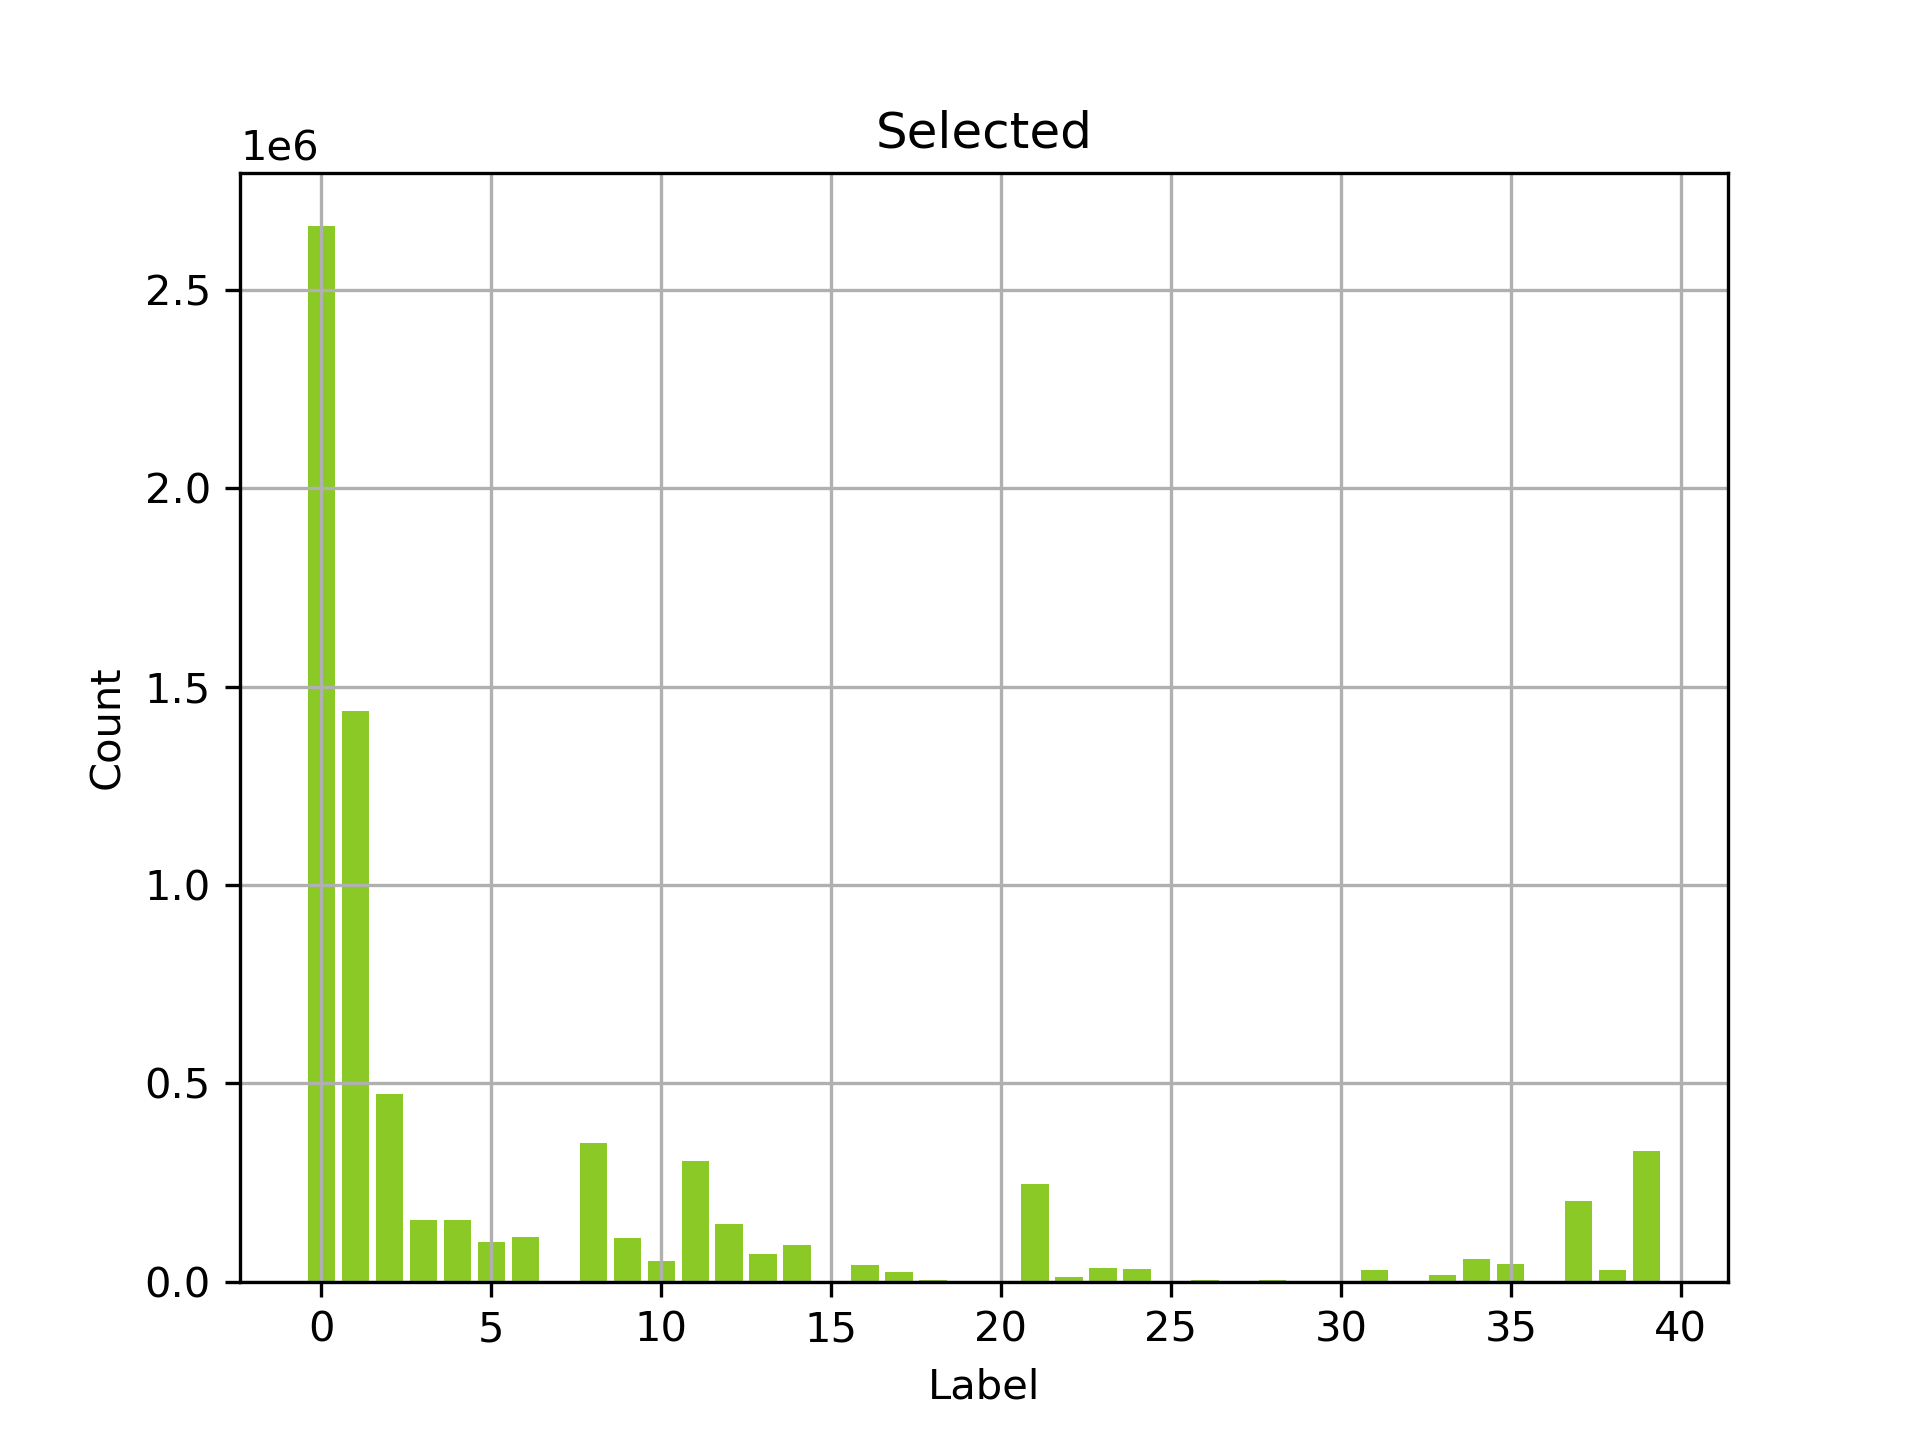

In [2]:
def test():
    from PIL import Image
    import os, sys
    
    import time
    
    os.chdir('/home/jonfrey/ASL')
    sys.path.append('/home/jonfrey/ASL')
    sys.path.append('/home/jonfrey/ASL/src')
    from visu import Visualizer
    
    vis = Visualizer('/home/jonfrey/tmp', logger=None, epoch=0, store=True, num_classes=41)

    features = torch.load( '/media/scratch1/jonfrey/models/master_thesis/dev/uncertainty_integration3/labels_tensor_0.pt')
    globale_indices = torch.load( '/media/scratch1/jonfrey/models/master_thesis/dev/uncertainty_integration3/indices_tensor_0.pt')

    st = time.time()
    selected, metric = distribution_matching(features)
    selected_globale_indices = globale_indices[selected]
    t =  time.time()-st
    print(selected.sum(), metric, 'Total time',t)                 
    # features = features_l.clone()
    # globale_indices = globale_indices_l.clone()
    # K_return=50
    # print(new_metric)
    
    res = vis.plot_bar(features.sum(dim=0), x_label='Label', y_label='Count',
            sort=False, reverse=True, title= 'All', 
            tag=f'Pixelwise_Class_Count_Task', method='left',jupyter=True)
    display(Image.fromarray(res))


    res = vis.plot_bar(features[selected,:].sum(dim=0), x_label='Label', y_label='Count',
            sort=False, reverse=True, title= 'Selected',
            tag=f'Pixelwise_Class_Count_Task', method='left',jupyter=True)

    
    display(Image.fromarray(res))

test()